In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_curve, auc

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Dense, Dropout, Flatten, TimeDistributed, LSTM, Input, Bidirectional, 
                                    RandomFlip, RandomRotation, RandomZoom, RandomContrast, GaussianNoise, BatchNormalization, RandomBrightness)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import regularizers

## **Pre-processing Dataset.**

In [27]:
# --- Konfigurasi ---
DATASET_PATH = r"Datasample/UADFV"
OUTPUT_PATH = "processed_data"
SEQUENCE_LENGTH = 30
IMG_SIZE = 96

# --- Inisialisasi Detektor Wajah ---
# Pastikan file 'haarcascade_frontalface_default.xml' ada di path yang benar
try:
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    print("Detektor wajah (Haar Cascade) berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat Haar Cascade: {e}")

# Buat direktori output jika belum ada
os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f"Direktori output '{OUTPUT_PATH}' siap.")

Detektor wajah (Haar Cascade) berhasil dimuat.
Direktori output 'processed_data' siap.


In [28]:
# --- LANGKAH 1: Kumpulkan semua path video dan labelnya ---
all_video_paths = []
all_labels = []
categories = ['real', 'fake']

print("--- Step 1: Gathering all video file paths ---")
for category in categories:
    category_path = os.path.join(DATASET_PATH, category)
    if not os.path.isdir(category_path):
        print(f"Warning: Directory not found for category '{category}'. Skipping.")
        continue
    
    video_files = [f for f in os.listdir(category_path) if f.lower().endswith('.mp4')]
    for video_file in video_files:
        all_video_paths.append(os.path.join(category_path, video_file))
        all_labels.append(category)

print(f"Total videos found: {len(all_video_paths)}")

--- Step 1: Gathering all video file paths ---
Total videos found: 98


In [29]:
# --- LANGKAH 2: Bagi daftar path video menjadi set train, validation, dan test (60-20-20) ---
print("\n--- Step 2: Splitting file paths into training, validation, and test sets ---")

# Pertama, bagi menjadi 60% train dan 40% sisanya (untuk validation dan test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_video_paths, all_labels,
    test_size=0.4,  # 40% akan menjadi gabungan validation dan test
    random_state=42,
    stratify=all_labels
)

# Kedua, bagi 40% sisanya menjadi 20% validation dan 20% test (50% dari sisa)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.5,  # 50% dari 40% adalah 20% dari total
    random_state=42,
    stratify=temp_labels
)

print(f"Training videos: {len(train_paths)}")
print(f"Validation videos: {len(val_paths)}")
print(f"Test videos: {len(test_paths)}")


--- Step 2: Splitting file paths into training, validation, and test sets ---
Training videos: 58
Validation videos: 20
Test videos: 20


In [30]:
# --- LANGKAH 3: Buat fungsi untuk memproses daftar video ---
def process_videos(video_paths, video_labels):
    """Fungsi ini mengambil daftar path video dan mengekstrak sekuens frame wajah."""
    sequences = []
    processed_labels = []
    
    for i, video_path in enumerate(video_paths):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Warning: Could not open video file {video_path}")
            continue

        frames = []
        while len(frames) < SEQUENCE_LENGTH:
            ret, frame = cap.read()
            if not ret:
                break
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)
            
            if len(faces) > 0:
                # Ambil wajah terbesar
                (x, y, w, h) = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)[0]
                face = frame[y:y+h, x:x+w]
                resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))
                frames.append(resized_face)
        
        cap.release()
        
        if len(frames) == SEQUENCE_LENGTH:
            sequences.append(frames)
            processed_labels.append(video_labels[i])
            print(f"  -> Processed '{os.path.basename(video_path)}'. Sequence ADDED.")
        else:
            print(f"  -> Skipped '{os.path.basename(video_path)}'. Not enough frames with faces found.")
            
    return np.array(sequences), np.array(processed_labels)

In [31]:
# --- LANGKAH 4: Proses setiap set data secara terpisah ---
print("\n--- Step 3: Processing TRAINING data ---")
X_train, y_train_str = process_videos(train_paths, train_labels)

print("\n--- Step 4: Processing VALIDATION data ---")
X_val, y_val_str = process_videos(val_paths, val_labels)

print("\n--- Step 5: Processing TEST data ---")
X_test, y_test_str = process_videos(test_paths, test_labels)


--- Step 3: Processing TRAINING data ---
  -> Processed '0030_fake.mp4'. Sequence ADDED.
  -> Processed '0020.mp4'. Sequence ADDED.
  -> Processed '0012.mp4'. Sequence ADDED.
  -> Processed '0038.mp4'. Sequence ADDED.
  -> Processed '0004.mp4'. Sequence ADDED.
  -> Processed '0045_fake.mp4'. Sequence ADDED.
  -> Processed '0021.mp4'. Sequence ADDED.
  -> Processed '0027_fake.mp4'. Sequence ADDED.
  -> Processed '0002.mp4'. Sequence ADDED.
  -> Processed '0009_fake.mp4'. Sequence ADDED.
  -> Processed '0041_fake.mp4'. Sequence ADDED.
  -> Processed '0012_fake.mp4'. Sequence ADDED.
  -> Processed '0006_fake.mp4'. Sequence ADDED.
  -> Processed '0015_fake.mp4'. Sequence ADDED.
  -> Processed '0029.mp4'. Sequence ADDED.
  -> Processed '0022.mp4'. Sequence ADDED.
  -> Processed '0044_fake.mp4'. Sequence ADDED.
  -> Processed '0041.mp4'. Sequence ADDED.
  -> Processed '0005_fake.mp4'. Sequence ADDED.
  -> Processed '0046_fake.mp4'. Sequence ADDED.
  -> Processed '0034_fake.mp4'. Sequence AD

In [32]:
# --- LANGKAH 5: Lakukan encoding pada label ---
print("\n--- Step 6: Encoding labels ---")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_str)
y_val = label_encoder.transform(y_val_str)
y_test = label_encoder.transform(y_test_str)

print(f"Label encoding: {list(label_encoder.classes_)} -> {label_encoder.transform(label_encoder.classes_)}")

print("\nPreprocessing complete!")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# --- LANGKAH 6: Simpan Hasil Preprocessing ---
# (Pastikan variabel OUTPUT_PATH dari Sel 2 masih ada)
print(f"\nMenyimpan data ke '{OUTPUT_PATH}'...")
np.save(os.path.join(OUTPUT_PATH, 'X_train.npy'), X_train)
np.save(os.path.join(OUTPUT_PATH, 'y_train.npy'), y_train)
np.save(os.path.join(OUTPUT_PATH, 'X_val.npy'), X_val)
np.save(os.path.join(OUTPUT_PATH, 'y_val.npy'), y_val)
np.save(os.path.join(OUTPUT_PATH, 'X_test.npy'), X_test)
np.save(os.path.join(OUTPUT_PATH, 'y_test.npy'), y_test)
np.save(os.path.join(OUTPUT_PATH, 'label_encoder.npy'), label_encoder.classes_)

# Simpan juga path untuk testing di Langkah 3
np.save(os.path.join(OUTPUT_PATH, 'test_paths.npy'), test_paths)

print("All processed data has been saved successfully! ✅")


--- Step 6: Encoding labels ---
Label encoding: [np.str_('fake'), np.str_('real')] -> [0 1]

Preprocessing complete!
Shape of X_train: (58, 30, 96, 96, 3)
Shape of y_train: (58,)
Shape of X_val: (20, 30, 96, 96, 3)
Shape of y_val: (20,)
Shape of X_test: (20, 30, 96, 96, 3)
Shape of y_test: (20,)

Menyimpan data ke 'processed_data'...
All processed data has been saved successfully! ✅


## Langkah 2: Model Training 

In [33]:
# --- Muat Data yang Sudah Diproses ---
print("--- Loading processed data ---")
OUTPUT_PATH = "processed_data"

X_train = np.load(os.path.join(OUTPUT_PATH, 'X_train.npy'))
y_train = np.load(os.path.join(OUTPUT_PATH, 'y_train.npy'))
X_val = np.load(os.path.join(OUTPUT_PATH, 'X_val.npy'))
y_val = np.load(os.path.join(OUTPUT_PATH, 'y_val.npy'))

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")

--- Loading processed data ---
Shape of X_train: (58, 30, 96, 96, 3)
Shape of X_val: (20, 30, 96, 96, 3)


In [34]:
# --- FEATURE EXTRACTION ---
input_shape = X_train.shape[1:]

base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape[1:]
)
base_model.trainable = False # Feature extraction only

# --- DATA AUGMENTATION ---
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.4),
    RandomZoom(0.4),
    RandomContrast(0.3),
    RandomBrightness(0.2),
    GaussianNoise(0.1)
], name='data_augmentation')

# --- ARSITEKTUR MODEL ---
model = Sequential([
    Input(shape=input_shape),
    TimeDistributed(data_augmentation),
    TimeDistributed(base_model),
    TimeDistributed(Flatten()),
    
    # Stacked Bidirectional LSTM dengan dropout
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
    BatchNormalization(),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.2)),
    BatchNormalization(),
    
    # Dense layers dengan regularisasi kuat
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 30, 96, 96, 3)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 30, 3, 3, 1280) │     5,919,312 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 30, 11520)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 30, 256)        │    11,928,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,038,609 (68.81 MB)

 Trainable params: 12,118,529 (46.23 MB)

 Non-trainable params: 5,920,080 (22.58 MB)

In [35]:
# --- COMPILE MODEL ---
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Class Weight ---
# (Berguna jika dataset tidak seimbang)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train.flatten()
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")

# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,       
    patience=3,        
    min_lr=0.00001,     
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras', # Simpan model terbaik selama pelatihan
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, checkpoint]

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
# --- Latih Model ---
print("\n--- Starting Model Training ---")

# Catatan: Anda menghitung class_weight_dict tapi tidak menggunakannya di model.fit().
# Jika data Anda tidak seimbang, tambahkan: class_weight=class_weight_dict
history = model.fit(
    X_train, y_train,
    epochs=100, # Beri epoch lebih banyak, biarkan early stopping yang bekerja
    batch_size=32,
    validation_data=(X_val, y_val), 
    callbacks=callbacks_list
)

model.save('final_deepfake_model.keras')
print("Model final berhasil disimpan!")


--- Starting Model Training ---
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4014 - loss: 3.3590   
Epoch 1: val_loss improved from None to 2.80131, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 661s 158s/step - accuracy: 0.3966 - loss: 3.2751 - val_accuracy: 0.5000 - val_loss: 2.8013 - learning_rate: 1.0000e-04
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5814 - loss: 3.1773  
Epoch 2: val_loss improved from 2.80131 to 2.79612, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 23s/step - accuracy: 0.5690 - loss: 3.1968 - val_accuracy: 0.5000 - val_loss: 2.7961 - learning_rate: 1.0000e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6940 - loss: 2.9532 
Epoch 3: val_loss improved from 2.79612 to 2.79200, saving model to best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 23s/step - accuracy: 0.6379 - loss: 3.0320 - val_accuracy: 0.5000 - val_loss: 2.7920 - learning_rate: 1.0000e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━

In [ ]:
# --- Visualisasi Accuracy dan Loss ---
print("\n--- Plotting Training History ---")
plt.figure(figsize=(14, 5))

# Subplot 1: Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Subplot 2: Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

## Langkah 3: Testing

Memuat model dari: final_deepfake_model.h5


Model berhasil dimuat.

--- Memulai Prediksi pada 20% Data Uji ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 105s 105s/step
Video: 0023_fake.mp4
  - Prediksi: **REAL** (Akurasi: 80.46%)
  - Sebenarnya: REAL
  - Status: ✅ BENAR

Video: 0036.mp4
  - Prediksi: **REAL** (Akurasi: 51.33%)
  - Sebenarnya: DEEPFAKE
  - Status: ❌ SALAH

Video: 0028_fake.mp4
  - Prediksi: **REAL** (Akurasi: 93.49%)
  - Sebenarnya: REAL
  - Status: ✅ BENAR

Video: 0018_fake.mp4
  - Prediksi: **REAL** (Akurasi: 93.65%)
  - Sebenarnya: REAL
  - Status: ✅ BENAR

Video: 0005.mp4
  - Prediksi: **REAL** (Akurasi: 86.81%)
  - Sebenarnya: DEEPFAKE
  - Status: ❌ SALAH

Video: 0019.mp4
  - Prediksi: **DEEPFAKE** (Akurasi: 97.95%)
  - Sebenarnya: DEEPFAKE
  - Status: ✅ BENAR

Video: 0014_fake.mp4
  - Prediksi: **REAL** (Akurasi: 93.72%)
  - Sebenarnya: REAL
  - Status: ✅ BENAR

Video: 0007_fake.mp4
  - Prediksi: **REAL** (Akurasi: 94.05%)
  - Sebenarnya: REAL
  - Status: ✅ BENAR

Video: 0016.mp4
  - Prediksi: **DEEPFAKE** (Akurasi: 52.57%)

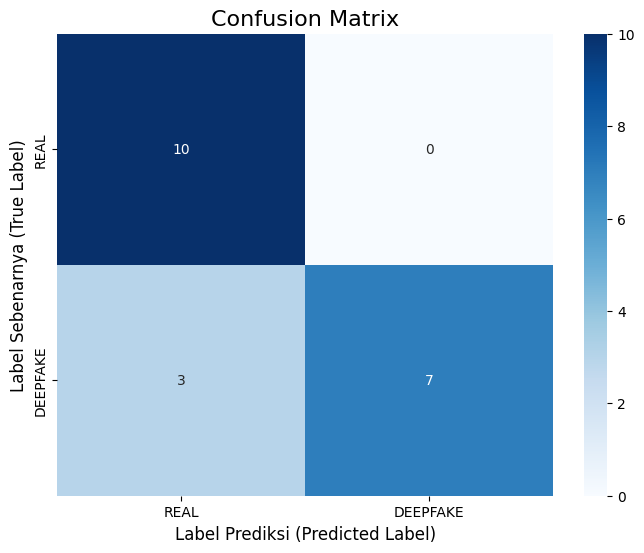


Menampilkan Kurva ROC...


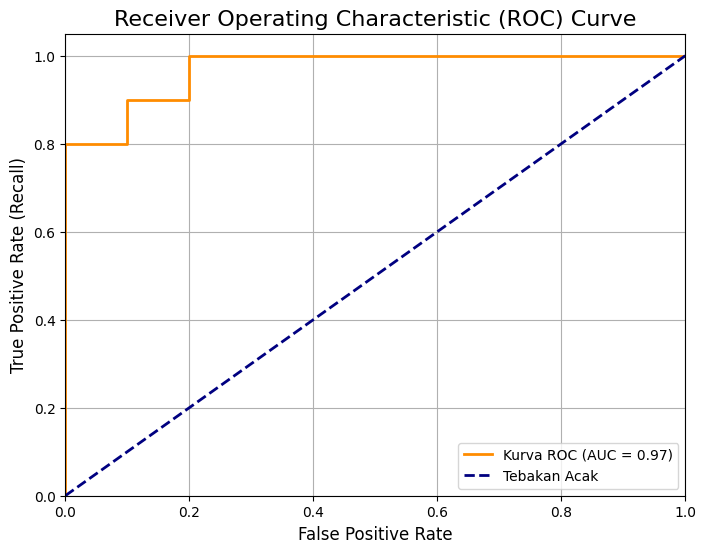

In [ ]:
# --- Muat Model dan Data Uji ---
MODEL_PATH = 'best_model.keras' 
OUTPUT_PATH = "processed_data"

print(f"Memuat model dari: {MODEL_PATH}")
try:
    # Muat model terbaik yang disimpan oleh ModelCheckpoint
    # (Jika 'best_model.h5' ada, itu mungkin lebih baik daripada 'final_deepfake_model.h5')
    model = load_model('best_model.h5') 
    print("Model terbaik (best_model.h5) berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat 'best_model.h5', mencoba 'final_deepfake_model.h5'. Error: {e}")
    try:
        model = load_model(MODEL_PATH)
        print("Model final (final_deepfake_model.h5) berhasil dimuat.")
    except Exception as e2:
        print(f"Gagal memuat kedua model: {e2}")

# Load data uji
X_test = np.load(os.path.join(OUTPUT_PATH, 'X_test.npy'))
y_test = np.load(os.path.join(OUTPUT_PATH, 'y_test.npy'))

# Load path file tes (disimpan di Sel 7)
test_paths = np.load(os.path.join(OUTPUT_PATH, 'test_paths.npy'))

print(f"Data uji dimuat: X_test {X_test.shape}, y_test {y_test.shape}, test_paths {len(test_paths)}")

In [ ]:
# --- Memulai Prediksi pada Data Uji ---
print("\n--- Memulai Prediksi pada 20% Data Uji ---")
predictions = model.predict(X_test)

# --- Tampilkan hasil untuk setiap video di test set ---
y_pred_labels = [] # Kumpulkan label untuk confusion matrix

for i in range(len(test_paths)):
    video_path = test_paths[i]
    true_label_int = y_test[i]
    confidence_score = predictions[i][0]
    
    predicted_label_int = 1 if confidence_score > 0.5 else 0
    y_pred_labels.append(predicted_label_int)
    
    predicted_label = "DEEPFAKE" if predicted_label_int == 1 else "REAL"
    true_label = "DEEPFAKE" if true_label_int == 1 else "REAL"
    
    video_filename = os.path.basename(video_path)
    display_accuracy = confidence_score if predicted_label == "DEEPFAKE" else 1 - confidence_score
    status = "✅ BENAR" if predicted_label == true_label else "❌ SALAH"
    
    print(
        f"Video: {video_filename}\n"
        f"  - Prediksi: **{predicted_label}** (Akurasi: {display_accuracy:.2%})\n"
        f"  - Sebenarnya: {true_label}\n"
        f"  - Status: {status}\n"
    )

print("\n--- Analisa Selesai ---")

In [ ]:
# --- Visualisasi Metrik Evaluasi ---
print("\nMenampilkan Confusion Matrix...")

class_names = ['REAL', 'DEEPFAKE']
y_pred_labels = np.array(y_pred_labels) # Konversi ke numpy array

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Label Sebenarnya (True Label)', fontsize=12)
plt.xlabel('Label Prediksi (Predicted Label)', fontsize=12)
plt.show()